# TRMM Preparación de datos

In [1]:
% matplotlib inline
import glob
import numpy as np
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

## Leer varios archivos y combinarlos en un solo conjunto de datos

In [2]:
files = glob.glob("./data/*.nc")
len(files)

242

### Usar / escribir algunas funciones auxiliares

In [3]:
# %load src/extract_timestep.py
def extract_timestep(ds):
    import re
    import datetime
    import numpy as np
    file_header = ds.attrs["FileHeader"]
    text = file_header.split(";")[5]
    match = re.search(r'\d{4}-\d{2}-\d{2}', text)
    date = datetime.datetime.strptime(match.group(), '%Y-%m-%d').date()
    return date

In [4]:
def read_netcdfs(paths):    
    datasets = [xr.open_dataset(p) for p in paths]
    for e, ds in enumerate(datasets):
        datasets[e] = ds.assign(time=np.datetime64(extract_timestep(ds)))
    combined = xr.concat(datasets, dim="time")
    return combined

### Cargar los archivos

In [5]:
file_paths = glob.glob("./data/*.nc")
ds = read_netcdfs(file_paths)

In [6]:
ds

<xarray.Dataset>
Dimensions:                 (nlat: 85, nlon: 63, time: 242)
Coordinates:
  * nlon                    (nlon) float32 -82.375 -82.125 -81.875 -81.625 ...
  * nlat                    (nlat) float32 -20.125 -19.875 -19.625 -19.375 ...
  * time                    (time) datetime64[ns] 1998-01-31 1998-02-28 ...
Data variables:
    precipitation           (time, nlat, nlon) float32 0.00064516126 ...
    relativeError           (time, nlat, nlon) float32 0.021309756 0.0193667 ...
    gaugeRelativeWeighting  (time, nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    Grid.GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatit...
    FileHeader:       AlgorithmID=3B43;\nAlgorithmVersion=3B43_7.0;\nFileName...
    FileInfo:         DataFormatVersion=m;\nTKCodeBuildVersion=1;\nMetadataVe...
    GridHeader:       BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatit...
    history:          2018-05-14 14:20:38 GMT Hyrax-1.13.4 https://disc2.gesd...

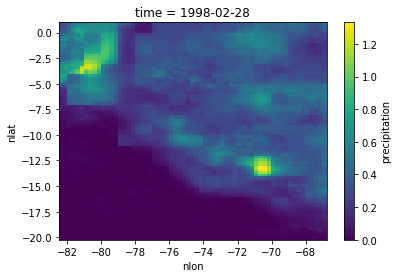

In [7]:
ds.sel(time=ds.time[1])["precipitation"].plot()

## Calcular mm por mes

In [8]:
def compute_mm_from_mm_per_hour(ds, days):
    return ds * 24 *  days

def process_data(ds):
    ds_temp = ds.copy(deep=True)
    for e, timestamp in enumerate(ds.coords["time"]):
        # get days a month
        days_a_month = pd.to_datetime(timestamp.values).day
        # subset data
        _ = ds_temp.sel(time=timestamp.values)["precipitation"]
        # compute mm/month
        prec_mm_per_month = compute_mm_from_mm_per_hour(_, days_a_month)
        # mask values lower than 1 
        #prec_mm_per_month = prec_mm_per_month.where(prec_mm_per_month >= 1)
        # reassign new values
        ds_temp["precipitation"][e] = prec_mm_per_month  
                
    return ds_temp 

In [9]:
ds_processed = process_data(ds)  
ds_processed

<xarray.Dataset>
Dimensions:                 (nlat: 85, nlon: 63, time: 242)
Coordinates:
  * nlon                    (nlon) float32 -82.375 -82.125 -81.875 -81.625 ...
  * nlat                    (nlat) float32 -20.125 -19.875 -19.625 -19.375 ...
  * time                    (time) datetime64[ns] 1998-01-31 1998-02-28 ...
Data variables:
    precipitation           (time, nlat, nlon) float32 0.48 0.03 0.12 ...
    relativeError           (time, nlat, nlon) float32 0.021309756 0.0193667 ...
    gaugeRelativeWeighting  (time, nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    Grid.GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatit...
    FileHeader:       AlgorithmID=3B43;\nAlgorithmVersion=3B43_7.0;\nFileName...
    FileInfo:         DataFormatVersion=m;\nTKCodeBuildVersion=1;\nMetadataVe...
    GridHeader:       BinMethod=ARITHMETIC_MEAN;\nRegistration=CENTER;\nLatit...
    history:          2018-05-14 14:20:38 GMT Hyrax-1.13.4 https://disc2.gesd...

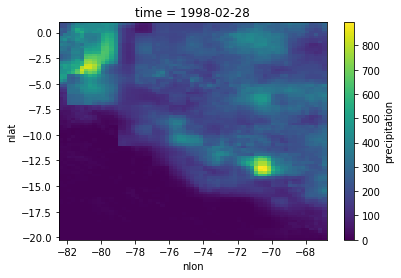

In [10]:
ds_processed.sel(time=ds_processed.time[1])["precipitation"].plot()

## Guardar el objeto en el disco como archivo `.nc` ([netcdf](https://en.wikipedia.org/wiki/NetCDF))

In [11]:
ds_processed.to_netcdf("./data/processed/peru.nc")